In [103]:
# import the library 
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, layers, datasets
import matplotlib.pyplot as plt
import random
import numpy as np

#!pip install fringe
#!pip install tensorflow-addons
from fringe.utils.io import import_image, export_image
from fringe.utils.modifiers import ImageToArray, ConvertToTensor
from fringe.process.gpu import AngularSpectrumSolver as AsSolver

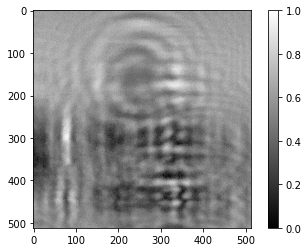

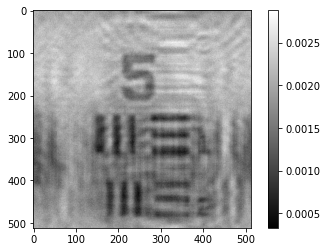

In [104]:
# load captured hologram image
folder_path = '/Users/chuckles/Desktop/Holographic Reconstruction/test image/'
file_name = 'target512_2'
hologram_path = folder_path+file_name+'.jpg'

p1 = ImageToArray(bit_depth=16, channel='gray', crop_window=None, dtype='float32')

hologram = import_image(hologram_path, modifiers=[p1])
hologram_amp = tf.math.abs(hologram)

solver = AsSolver(shape=hologram_amp.shape, dx=1.12, dy=1.12, wavelength=650e-3)

def Scale(img, perc, max_val):
	img *= perc
	img += 1 - perc
	img /= max_val
	return img
  
# Adjusting contrast
hologram_amp = Scale(hologram_amp, perc=1, max_val=np.max(hologram_amp))

rec = solver.solve(hologram, 8450)
amp = np.abs(rec)

plt.imshow(hologram_amp, cmap='gray', )
plt.colorbar()
plt.show()
plt.imshow(amp, cmap='gray')
plt.colorbar()
plt.show()


In [105]:
class decoder(Model):
    def __init__(self, input_dim=(16, 16, 256), **kwargs):
        super().__init__()
        self.input_dim = input_dim
        self.model = self.make_model()

    def make_model(self):
        input_layer = layers.Input(shape=self.input_dim, name='input_layer')
        x = input_layer
        for i in range(5):
            conv1 = layers.Conv2D(256, 1, activation='relu', strides=1, padding='same')
            upsample1 = layers.UpSampling2D(interpolation='bilinear')
            relu1 = layers.ReLU()
            batchnorm1 = layers.BatchNormalization(trainable=True)
            x = conv1(x)
            x = upsample1(x)
            x = relu1(x)
            x = batchnorm1(x)
        conv2 = layers.Conv2D(2, 1, activation='relu', strides=1, padding='same')
        outact1 = layers.Activation('sigmoid')
        x = conv2(x)
        x = outact1(x)
        return Model(inputs=input_layer, outputs=x)

    def call(self, x):
        return self.model(x)

model = decoder()
model.build(input_shape=(1, 16, 16, 256))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


Model: "decoder_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_16 (Functional)        (None, 512, 512, 2)       334594    
Total params: 334,594
Trainable params: 332,034
Non-trainable params: 2,560
_________________________________________________________________


In [106]:
dtype_f = tf.float32

random_seed = 867
print("Random Seed: ", random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

input_t_ref = tf.random.normal([1, 16, 16, 256], mean=0, stddev=0.1, dtype=dtype_f)
input_t = tf.Variable(input_t_ref)

Random Seed:  867


Epoch 000: Loss: 0.01404


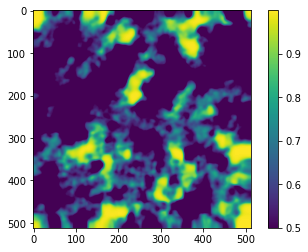

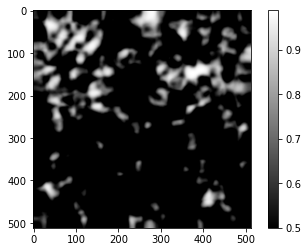

Epoch 020: Loss: 0.04737
Epoch 040: Loss: 0.03155
Epoch 060: Loss: 0.02582
Epoch 080: Loss: 0.02076
Epoch 100: Loss: 0.01782


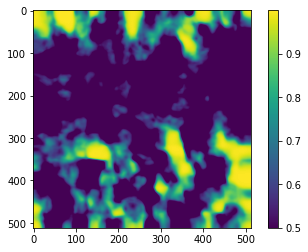

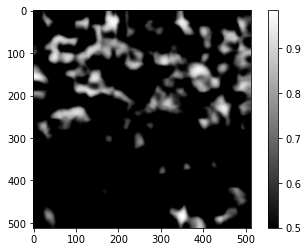

Epoch 120: Loss: 0.01664
Epoch 140: Loss: 0.01580
Epoch 160: Loss: 0.01463
Epoch 180: Loss: 0.01390
Epoch 200: Loss: 0.01339


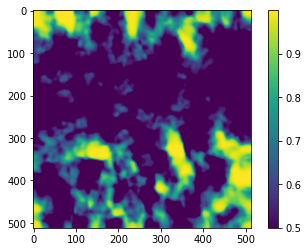

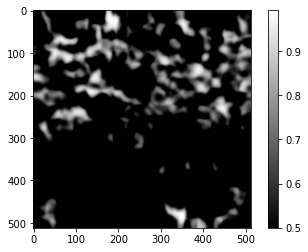

Epoch 220: Loss: 0.01271
Epoch 240: Loss: 0.01321
Epoch 260: Loss: 0.01171
Epoch 280: Loss: 0.01138
Epoch 300: Loss: 0.01118


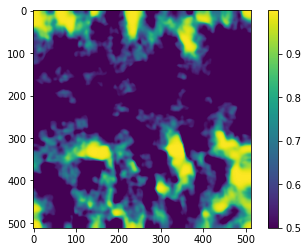

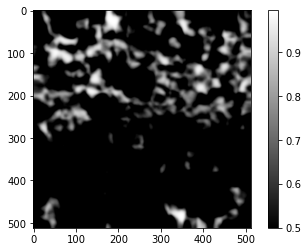

Epoch 320: Loss: 0.01046
Epoch 340: Loss: 0.01052
Epoch 360: Loss: 0.01022
Epoch 380: Loss: 0.01008
Epoch 400: Loss: 0.00895


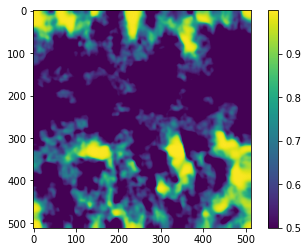

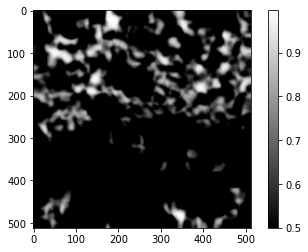

Epoch 420: Loss: 0.00872
Epoch 440: Loss: 0.00875
Epoch 460: Loss: 0.00833
Epoch 480: Loss: 0.00801
Epoch 500: Loss: 0.00836


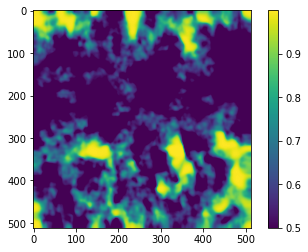

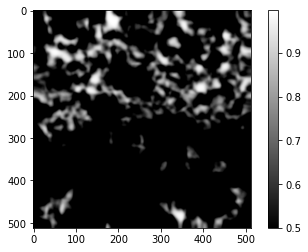

Epoch 520: Loss: 0.00812
Epoch 540: Loss: 0.00789
Epoch 560: Loss: 0.00787
Epoch 580: Loss: 0.00747
Epoch 600: Loss: 0.00699


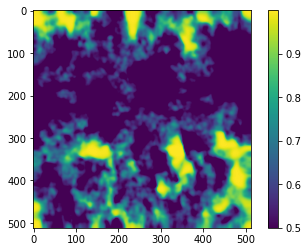

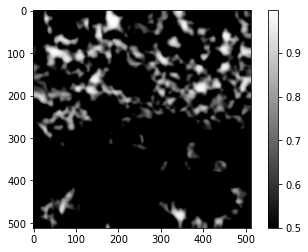

Epoch 620: Loss: 0.00682
Epoch 640: Loss: 0.00675
Epoch 660: Loss: 0.00633
Epoch 680: Loss: 0.00711
Epoch 700: Loss: 0.00629


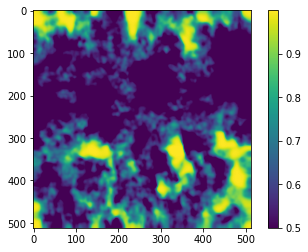

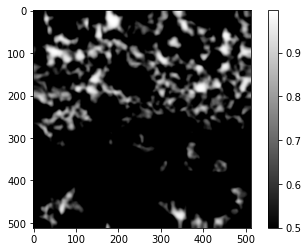

Epoch 720: Loss: 0.00659
Epoch 740: Loss: 0.00633
Epoch 760: Loss: 0.00609
Epoch 780: Loss: 0.00586
Epoch 800: Loss: 0.00598


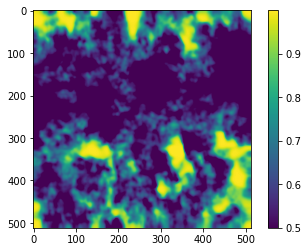

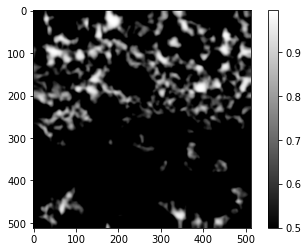

Epoch 820: Loss: 0.00607
Epoch 840: Loss: 0.00581
Epoch 860: Loss: 0.00557
Epoch 880: Loss: 0.00586
Epoch 900: Loss: 0.00530


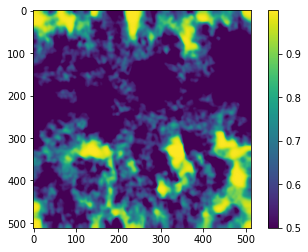

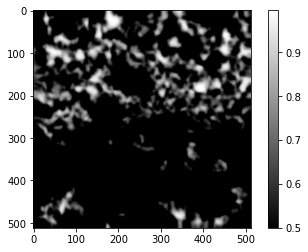

Epoch 920: Loss: 0.00543
Epoch 940: Loss: 0.00564
Epoch 960: Loss: 0.00543
Epoch 980: Loss: 0.00542


In [108]:
num_epochs = 1000
amp_coef = 1.3
trainable_variables = model.trainable_variables
mse = tf.keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
z = 8400

for epoch in range(num_epochs):
    with tf.GradientTape(persistent=True) as tape:

        out = model(input_t, training=True)
        out = tf.squeeze(out)

        out_ph = out[..., 0]
        out_ph = tf.scalar_mul(2 * np.pi, out_ph)
        out_ph = tf.complex(real=tf.zeros_like(out_ph), imag=out_ph)

        out_amp = out[..., 1]
        out_amp = tf.scalar_mul(amp_coef, out_amp)
        out_amp = tf.complex(real=out_amp, imag=tf.zeros_like(out_amp))
        out_func = tf.multiply(out_amp, tf.math.exp(out_ph))

        out_hol = solver.solve(out_func, z)
        out_hol_amp = tf.math.pow(tf.math.abs(out_hol), 2)

        loss_value = mse(out_hol_amp, hologram_amp)

    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))

    if epoch % 20 == 0:
        print("Epoch {:03d}: Loss: {:.5f}".format(epoch, loss_value))
    if epoch % 100 == 0:
        plt.imshow(out[...,0].numpy())
        plt.colorbar()
        plt.show()
        plt.imshow(out[...,1].numpy(), cmap='gray')
        plt.colorbar()
        plt.show()

        

In [ ]:
checkpoint_path = "./checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)